In [2]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots

include("../helpers.jl")
include("../stats.jl")

updatescoresdict! (generic function with 2 methods)

## Edit before running on new data

In [3]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [7]:
# get data
x_raw_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_raw_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_raw_df, y_raw_df = readjsonsfromdirectory(target_directory, x_raw_df, y_raw_df);

In [8]:
first(x_raw_df, 5)

,DVAR1,DVAR2,DVAR3,DVAR4,DVAR5,DVAR6,DVAR7,DVAR8,DVAR9
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,10.7561,51.3217,117.941,1.58493,1.80198,54.7152,46.9082,-73.5071,-40.3815
2,10.9999,59.0984,114.967,1.42384,1.632,94.2397,329.885,-69.9227,-61.021
3,10.5114,67.2372,102.822,1.56805,1.76104,232.236,482.175,-34.481,-31.0546
4,9.79078,132.062,157.89,1.06108,1.4818,91.7427,178.76,-35.0063,-28.2593
5,10.8851,33.3697,144.044,1.67219,1.83251,433.296,420.627,-32.8443,-26.0774


In [9]:
first(y_raw_df, 5)

,OBJ1,OBJ2,OBJ3,OBJ4,OBJ5,OBJ6
,Float32,Float32,Float32,Float32,Float32,Float32
1,91.0,0.0624,99.34,0.07639,0.07035,0.05352
2,92.69,0.0579,110.26,0.07544,0.03639,0.05048
3,70.87,0.0649,80.55,0.07192,0.04194,0.02244
4,16.85,0.0756,183.99,0.01274,0.01483,0.01153
5,66.16,0.0674,56.7,0.06682,0.03004,0.04468


## EDA

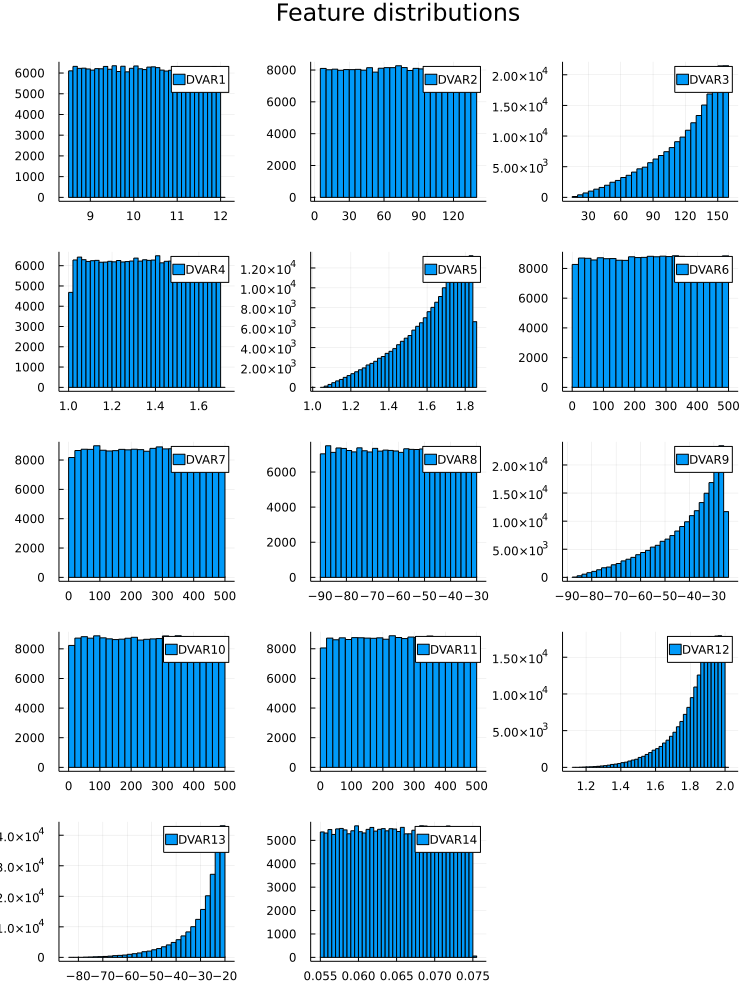

In [10]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_raw_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

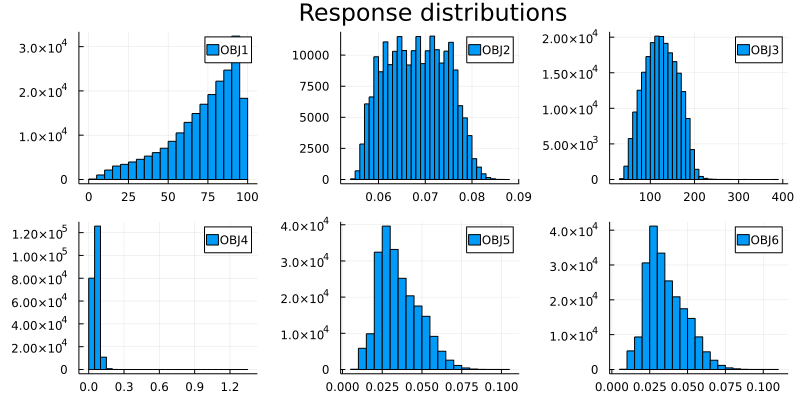

In [11]:
# plot responses
l = @layout [grid(2,3)]

subplots = []
for i in 1:6
    hist = histogram(y_raw_df[:, "OBJ$i"], label="OBJ$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout = l, size=(800, 400), plot_title="Response distributions")

In [12]:
# some cuts
abnormally_high_rfq_length = 220. # OBJ3
abnormally_high_longitudinal_emittance = 0.2 # OBJ4
abnormally_high_x_emittance = 0.08 # OBJ5
abnormally_high_y_emittance = 0.08 # OBJ6

non_outlier_conditional = (y_raw_df[:, "OBJ3"] .<= abnormally_high_rfq_length) .&
    (y_raw_df[:, "OBJ4"] .<= abnormally_high_longitudinal_emittance) .&
    (y_raw_df[:, "OBJ5"] .<= abnormally_high_x_emittance) .&
    (y_raw_df[:, "OBJ6"] .<= abnormally_high_y_emittance)

# process data
x_outliers_df = x_raw_df[(!).(non_outlier_conditional), :];
y_outliers_df = y_raw_df[(!).(non_outlier_conditional), :];

x_df = x_raw_df[non_outlier_conditional, :];
y_df = y_raw_df[non_outlier_conditional, :];

In [13]:
# how many outliers are there?
sum((!).(non_outlier_conditional))

717

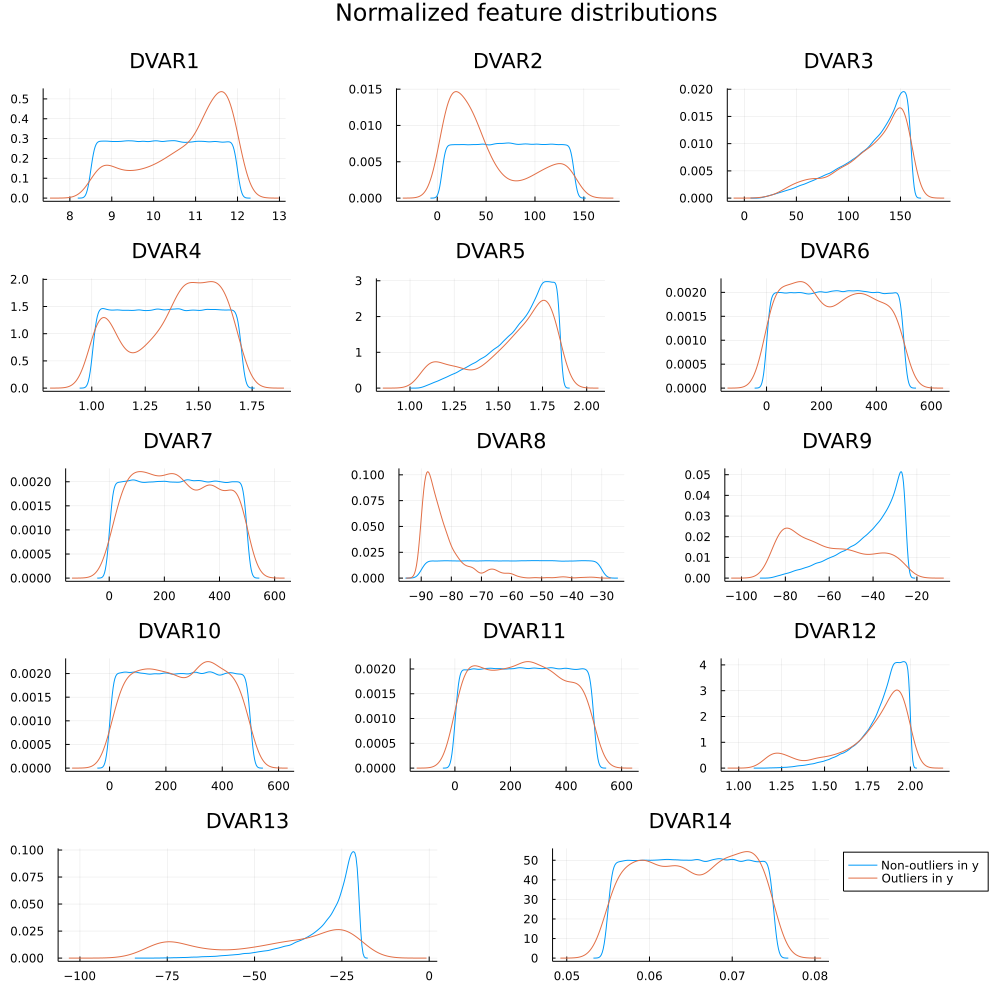

In [14]:
# features split by outlier
l = @layout [a b c; d e f; g h i; j k l; m n]

subplots = []
for i in 1:14
    sp = density(x_df[:, "DVAR$i"]; label=(i == 14 ? "Non-outliers in y" : ""), legend=(i==14), title="DVAR$i")
    density!(sp, x_outliers_df[:, "DVAR$i"]; label=(i == 14 ? "Outliers in y" : ""), legend=:outertopright)
    push!(subplots, sp)
end

plot(subplots..., layout=l, size=(1000, 1000), plot_title="Normalized feature distributions")

## Data preprocessing

In [15]:
# scaler
mutable struct MinMaxScaler
    data_min::Float64
    data_max::Float64
end

function fit!(scaler, data)
    scaler.data_min = minimum(data); scaler.data_max = maximum(data)
end

function transform(scaler, data)
    [2*(d - scaler.data_min)/(scaler.data_max - scaler.data_min) - 1 for d in data]
end

function inverse_transform(scaler, data_scaled)
    [0.5*(scaler.data_max - scaler.data_min)*(d_s + 1) + scaler.data_min for d_s in data_scaled]
end

function fit_transform(data)
    scaler = MinMaxScaler(0., 0.)
    fit!(scaler, data)
    transform(scaler, data)
end

# sanity checking
data_test = [1., 2., 3., 4., 5.]
scaler_test = MinMaxScaler(0., 0.)
fit!(scaler_test, data_test)
data_test_scaled = transform(scaler_test, data_test)
@assert(maximum(data_test_scaled) == 1.0)
@assert(minimum(data_test_scaled) == -1.0)
@assert(maximum(data_test) == maximum(inverse_transform(scaler_test, data_test_scaled)))
@assert(minimum(data_test) == minimum(inverse_transform(scaler_test, data_test_scaled)))

LoadError: invalid redefinition of type MinMaxScaler

In [16]:
# drop any columns needed
select!(x_df, Not(x_columns_to_drop));
select!(y_df, Not(y_columns_to_drop));

In [17]:
# scaling data
x_scaled_df = hcat(DataFrame.(colname=>fit_transform(x_df[!, colname]) for colname in names(x_df))...)
y_scaled_df = hcat(DataFrame.(colname=>fit_transform(y_df[!, colname]) for colname in names(y_df))...)

@assert(all(maximum(x_scaled_df[!, colname]) == 1. for colname in names(x_scaled_df)))
@assert(all(minimum(x_scaled_df[!, colname]) == -1. for colname in names(x_scaled_df)))

In [18]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [19]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

In [20]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [21]:
# some other loss functions / metrics
max_valueormachinelimit(x) = max(x, eps())

# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [22]:
# organizing data into batches
batch_size = 512
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [ ]:
# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM()
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 2500
training_losses = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=30.00723283737898
epoch 2, loss=11.470942443236709
epoch 3, loss=8.410225393250585
epoch 4, loss=7.623517321422696
epoch 5, loss=6.990814670920372
epoch 6, loss=6.437066873535514
epoch 7, loss=6.014427247457206
epoch 8, loss=5.721479500643909
epoch 9, loss=5.5264671836048365
epoch 10, loss=5.366797507740557
epoch 11, loss=5.246742272749543
epoch 12, loss=5.164620635099709
epoch 13, loss=5.021768122911453
epoch 14, loss=4.9179363027215
epoch 15, loss=4.840311688371003
epoch 16, loss=4.755549140274525
epoch 17, loss=4.689936782233417
epoch 18, loss=4.646583390422165
epoch 19, loss=4.619259440340102
epoch 20, loss=4.513850758783519
epoch 21, loss=4.48500035982579
epoch 22, loss=4.4325282368808985
epoch 23, loss=4.338460412807763
epoch 24, loss=4.3233696250244975
epoch 25, loss=4.34911709651351
epoch 26, loss=4.212765243835747
epoch 27, loss=4.1892290115356445
epoch 28, loss=4.137238012626767
epoch 29, loss=4.051307959482074
epoch 30, loss=4.0121759762987494
epoch 31, loss=4.

epoch 241, loss=3.1443235855549574
epoch 242, loss=3.1545380540192127
epoch 243, loss=3.1665560454130173
epoch 244, loss=3.1642406368628144
epoch 245, loss=3.1509993826039135
epoch 246, loss=3.156522238627076
epoch 247, loss=3.1771270548924804
epoch 248, loss=3.1731617022305727
epoch 249, loss=3.1573368031531572
epoch 250, loss=3.1485701724886894
epoch 251, loss=3.1426514675840735
epoch 252, loss=3.180231516249478
epoch 253, loss=3.134065927937627
epoch 254, loss=3.131910575553775
epoch 255, loss=3.1361684845760465
epoch 256, loss=3.142125085927546
epoch 257, loss=3.1352010685950518
epoch 258, loss=3.155220413580537
epoch 259, loss=3.1329923728480935
epoch 260, loss=3.140966784209013
epoch 261, loss=3.143401701003313
epoch 262, loss=3.156756455078721
epoch 263, loss=3.159224751405418
epoch 264, loss=3.1612367322668433
epoch 265, loss=3.129539081826806
epoch 266, loss=3.1285027358680964
epoch 267, loss=3.1246808571740985
epoch 268, loss=3.1315769283100963
epoch 269, loss=3.1522263502702

epoch 479, loss=3.0423721252009273
epoch 480, loss=3.0162779637612402
epoch 481, loss=3.02036366565153
epoch 482, loss=3.036888802424073
epoch 483, loss=3.042884883005172
epoch 484, loss=3.0144239515066147
epoch 485, loss=3.013382337987423
epoch 486, loss=3.0277215652167797
epoch 487, loss=3.0107297990471125
epoch 488, loss=3.013105170801282
epoch 489, loss=3.0137313692830503
epoch 490, loss=3.014276041649282
epoch 491, loss=3.0133896451443434
epoch 492, loss=3.0096606984734535
epoch 493, loss=3.026571663096547
epoch 494, loss=3.029603441245854
epoch 495, loss=3.0160365272313356
epoch 496, loss=3.0050662579014897
epoch 497, loss=3.0118466382846236
epoch 498, loss=3.024148953612894
epoch 499, loss=3.0114811579696834
epoch 500, loss=3.0096440385095775
epoch 501, loss=2.999394907616079
epoch 502, loss=3.015606884844601
epoch 503, loss=3.0219787042587996
epoch 504, loss=2.9952088184654713
epoch 505, loss=2.997566018719226
epoch 506, loss=2.9960058494471014
epoch 507, loss=3.014951325953006

epoch 717, loss=2.902286970987916
epoch 718, loss=2.9001099220477045
epoch 719, loss=2.9020336284302175
epoch 720, loss=2.8950077276676893
epoch 721, loss=2.9013919322751462
epoch 722, loss=2.9085066369734704
epoch 723, loss=2.922033430542797
epoch 724, loss=2.903306540567428
epoch 725, loss=2.9033752949908376
epoch 726, loss=2.8973016515374184
epoch 727, loss=2.901891296263784
epoch 728, loss=2.901009046472609
epoch 729, loss=2.8969396324828267
epoch 730, loss=2.902437596116215
epoch 731, loss=2.8936982061713934
epoch 732, loss=2.8951102341525257
epoch 733, loss=2.907867784611881
epoch 734, loss=2.9124736497178674
epoch 735, loss=2.8951164055615664
epoch 736, loss=2.9027384407818317
epoch 737, loss=2.9248216785490513
epoch 738, loss=2.9146320642903447
epoch 739, loss=2.898353816010058
epoch 740, loss=2.8887968389317393
epoch 741, loss=2.948807515669614
epoch 742, loss=2.8878314774483442
epoch 743, loss=2.886105297598988
epoch 744, loss=2.8963674074038863
epoch 745, loss=2.899832837749

epoch 955, loss=2.8249893533065915
epoch 956, loss=2.8359746476635337
epoch 957, loss=2.840529809705913
epoch 958, loss=2.8396843033842742
epoch 959, loss=2.8180843922309577
epoch 960, loss=2.823791421484202
epoch 961, loss=2.825734644662589
epoch 962, loss=2.828537153545767
epoch 963, loss=2.818896524142474
epoch 964, loss=2.8258223375305533
epoch 965, loss=2.830078707076609
epoch 966, loss=2.8413958265446126
epoch 967, loss=2.824761333875358
epoch 968, loss=2.8256341251544654
epoch 969, loss=2.817017177119851
epoch 970, loss=2.833263974636793
epoch 971, loss=2.8154964777641
epoch 972, loss=2.8191323643550277
epoch 973, loss=2.8343352749943733
epoch 974, loss=2.82273823954165
epoch 975, loss=2.819142724853009
epoch 976, loss=2.826678817626089
epoch 977, loss=2.818096785340458
epoch 978, loss=2.828452513087541
epoch 979, loss=2.8336040088906884
epoch 980, loss=2.8448069007135928
epoch 981, loss=2.8221470657736063
epoch 982, loss=2.815841182600707
epoch 983, loss=2.8316131881438196
epoc

epoch 1187, loss=2.780247632879764
epoch 1188, loss=2.776197829283774
epoch 1189, loss=2.774428271688521
epoch 1190, loss=2.778312658891082
epoch 1191, loss=2.78074366459623
epoch 1192, loss=2.7803307520225644
epoch 1193, loss=2.7795175397768617
epoch 1194, loss=2.7765544089488685
epoch 1195, loss=2.7671957393176854
epoch 1196, loss=2.7709890720434487
epoch 1197, loss=2.7828337349928916
epoch 1198, loss=2.8120974814519286
epoch 1199, loss=2.7865283507853746
epoch 1200, loss=2.7688189186155796
epoch 1201, loss=2.7671065400354564
epoch 1202, loss=2.7785936961881816
epoch 1203, loss=2.7763601285405457
epoch 1204, loss=2.7689535561949015
epoch 1205, loss=2.781687412876636
epoch 1206, loss=2.7770856637507677
epoch 1207, loss=2.773386346641928
epoch 1208, loss=2.7754970346577466
epoch 1209, loss=2.766492288094014
epoch 1210, loss=2.7651770771481097
epoch 1211, loss=2.772528620902449
epoch 1212, loss=2.7839823425747454
epoch 1213, loss=2.783675908576697
epoch 1214, loss=2.7772457115352154
epo

epoch 1417, loss=2.7519653225317597
epoch 1418, loss=2.7417880059219897
epoch 1419, loss=2.747896204702556
epoch 1420, loss=2.74143140995875
epoch 1421, loss=2.7474407753907144
epoch 1422, loss=2.736059624236077
epoch 1423, loss=2.745618544984609
epoch 1424, loss=2.739456935785711
epoch 1425, loss=2.736563310492784
epoch 1426, loss=2.7419503149576485
epoch 1427, loss=2.7326264600269496
epoch 1428, loss=2.729379109106958
epoch 1429, loss=2.743086182512343
epoch 1430, loss=2.7412955057807267
epoch 1431, loss=2.738629102706909
epoch 1432, loss=2.7392537780106068
epoch 1433, loss=2.7421377887949347
epoch 1434, loss=2.7304684026166797
epoch 1435, loss=2.7348346314392984
epoch 1436, loss=2.7299684416502714
epoch 1437, loss=2.7366308574564755
epoch 1438, loss=2.7378360289148986
epoch 1439, loss=2.7384643056429923
epoch 1440, loss=2.730921348091215
epoch 1441, loss=2.7315763221122324
epoch 1442, loss=2.730141611304134
epoch 1443, loss=2.7461831900291145
epoch 1444, loss=2.763025613501668
epoch

epoch 1648, loss=2.7109656231477857
epoch 1649, loss=2.7033156999386847
epoch 1650, loss=2.70889230677858
epoch 1651, loss=2.714554892387241
epoch 1652, loss=2.7028899719007313
epoch 1653, loss=2.719402995426208
epoch 1654, loss=2.7088865330442786
epoch 1655, loss=2.701548047363758
epoch 1656, loss=2.709732197690755
epoch 1657, loss=2.7070180806331336
epoch 1658, loss=2.7014670623466372
epoch 1659, loss=2.704093042295426
epoch 1660, loss=2.6981175052933395
epoch 1661, loss=2.7076693032868207
epoch 1662, loss=2.70456480467692
epoch 1663, loss=2.698884221725166
epoch 1664, loss=2.701045964844525
epoch 1665, loss=2.7131460048258305
epoch 1666, loss=2.6971070263534784
epoch 1667, loss=2.704542029183358
epoch 1668, loss=2.705278606619686
epoch 1669, loss=2.7022990016266704
epoch 1670, loss=2.712841750588268
epoch 1671, loss=2.698777552228421
epoch 1672, loss=2.697311979252845
epoch 1673, loss=2.7073981668800116
epoch 1674, loss=2.6972534554079175
epoch 1675, loss=2.700857146177441
epoch 167

epoch 1879, loss=2.677198820747435
epoch 1880, loss=2.679489224217832
epoch 1881, loss=2.691187174990773
epoch 1882, loss=2.6909397151321173
epoch 1883, loss=2.6991013884544373
epoch 1884, loss=2.6921611865982413
epoch 1885, loss=2.680773998145014
epoch 1886, loss=2.683912993874401
epoch 1887, loss=2.6784729454666376
epoch 1888, loss=2.685719764791429
epoch 1889, loss=2.6854085149243474
epoch 1890, loss=2.6837791460566223
epoch 1891, loss=2.684083392843604
epoch 1892, loss=2.691852830350399
epoch 1893, loss=2.6803313489072025
epoch 1894, loss=2.6767859403043985
epoch 1895, loss=2.677819150965661
epoch 1896, loss=2.6888883439823985
epoch 1897, loss=2.6916547445580363
epoch 1898, loss=2.6861399793997407
epoch 1899, loss=2.6739819506183267
epoch 1900, loss=2.6812069853767753
epoch 1901, loss=2.690678774379194
epoch 1902, loss=2.701487004291266
epoch 1903, loss=2.688572648447007
epoch 1904, loss=2.684691907837987
epoch 1905, loss=2.6771997581236064
epoch 1906, loss=2.699715693015605
epoch 

epoch 2109, loss=2.6580207757651806
epoch 2110, loss=2.6671238923445344
epoch 2111, loss=2.665339062921703
epoch 2112, loss=2.6641551703214645
epoch 2113, loss=2.663006821181625
epoch 2114, loss=2.658563722856343
epoch 2115, loss=2.6703472156077623
epoch 2116, loss=2.6697029005736113
epoch 2117, loss=2.6747125778347254
epoch 2118, loss=2.6547737400978804
epoch 2119, loss=2.656743412371725
epoch 2120, loss=2.6772913690656424
epoch 2121, loss=2.6580798709765077
epoch 2122, loss=2.6570260785520077
epoch 2123, loss=2.6690980731509626
epoch 2124, loss=2.663966979831457
epoch 2125, loss=2.6796298138797283
epoch 2126, loss=2.6667175348848104
epoch 2127, loss=2.6618065582588315
epoch 2128, loss=2.653412508778274
epoch 2129, loss=2.65636898111552
epoch 2130, loss=2.6562054795213044
epoch 2131, loss=2.6735254214145243
epoch 2132, loss=2.6610023719258606
epoch 2133, loss=2.6764779943041503
epoch 2134, loss=2.658875093795359
epoch 2135, loss=2.656973988749087
epoch 2136, loss=2.6578874462284148
ep

epoch 2339, loss=2.646473444532603
epoch 2340, loss=2.644315545912832
epoch 2341, loss=2.654571165330708
epoch 2342, loss=2.648073060438037
epoch 2343, loss=2.6505150799639523
epoch 2344, loss=2.656665455084294
epoch 2345, loss=2.648992735426873
epoch 2346, loss=2.6472403993830085
epoch 2347, loss=2.6570713934488595
epoch 2348, loss=2.6584830307401717
epoch 2349, loss=2.6417219028808177
epoch 2350, loss=2.6420537726953626
epoch 2351, loss=2.6400464070029557
epoch 2352, loss=2.6414843993261456
epoch 2353, loss=2.655081299133599
epoch 2354, loss=2.6592031461186707
epoch 2355, loss=2.6510502314195037
epoch 2356, loss=2.6402532714419067
epoch 2357, loss=2.6417583096772432
epoch 2358, loss=2.6626809714362025
epoch 2359, loss=2.6436864347197115
epoch 2360, loss=2.6477605854161084
epoch 2361, loss=2.6441965964622796
epoch 2362, loss=2.6413238141685724
epoch 2363, loss=2.64353588456288
epoch 2364, loss=2.6428233138285577
epoch 2365, loss=2.644822519272566
epoch 2366, loss=2.646190147846937
epo

In [ ]:
# plot training history
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [ ]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

In [ ]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

In [ ]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

In [ ]:
size(x_train, 2)

In [ ]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

In [ ]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

In [ ]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

In [ ]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

In [ ]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

In [ ]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")